<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 6: Linear Model Selection and Regularisation</h2></center>
<br>

In this tutorial we will study how to implement variable selection, regularisation, and dimension reduction methods for linear regression in Python. Some of the code required is in the <TT>statlearning.py</TT> module, which you should have in the same folder as you are running Jupyter from. 

<a class="buttom" href="#Data">Data</a> <br>
<a class="buttom" href="#Exploratory-data-analysis">Exploratory data analysis</a> <br>
<a class="buttom" href="#Standardising-the-predictors">Standardising the predictors</a> <br>
<a class="buttom" href="#OLS">OLS</a> <br>
<a class="buttom" href="#Variable-selection">Variable selection</a> <br>
<a class="buttom" href="#Regularisation-methods">Regularisation methods</a> <br>
<a class="buttom" href="#Dimension-reduction-methods">Dimension reduction methods</a> <br>
<a class="buttom" href="#Cross-validation-results">Cross validation results</a> <br>
<a class="buttom" href="#Test-results">Test results</a> <br>


This notebook relies on the following imports and settings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_context('notebook') 
sns.set_style('ticks')

###Data

Our analysis will be based on a customer acquisition and profitability dataset.  

In [2]:
data = pd.read_excel('CustomerAcquisition.xls', index_col=[0])
data.head()

,Acquisition,First_Purchase,CLV,Duration,Censor,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Crossbuy,Frequency,Frequency_SQ
Customer,,,,,,,,,,,,,,,
1,1,433.64,0.0000,384,0,760.36,578147.33,1,30.16,1240,2309.79,5335129.84,5,2,4
2,0,0.00,0.0000,0,0,147.70,21815.29,1,39.80,166,0.00,0.00,0,0,0
3,0,0.00,0.0000,0,0,252.56,63786.55,1,54.93,1016,0.00,0.00,0,0,0
4,1,225.84,5.7316,730,1,609.73,371770.67,1,45.83,122,2192.59,4807450.91,2,12,144
5,1,363.04,0.0000,579,0,672.36,452067.97,1,69.03,313,801.14,641825.30,4,7,49


The objective of this type of analysis is to predict the profitability of a customer, which involves both classification and regression tasks. We apply classification methods to predict whether a customer will be acquired and retained, and regression methods to estimate the profitability of acquired and retained customer.  Here, we focus on this regression task. A more complete model can include all parts of the customer cycle. 

The response variable for this tutorial is the customer lifetime value (CLV, a measure of profitability) of customers who were acquired and remained as customers by the end of the observation window (730 days). These customers are identified with a value of one for the <TT>Censor</TT> variable.

In [3]:
data = data[data['Censor']==1]

The predictors are the value of the first purchase, dollars spent on marketing expenses for acquiring and retaining the customer, industry, revenue and number of employees of the customer, the number of product categories the customer purchased, and the number of times the customer purchased during the observation window.

It is important to recognise that linear model selection and regularisation methods only tend to lead to substantial improvements in performance over OLS in relatively complex settings (or with small sample sizes). For example, if you try Exercises 8 and 9 in Chapter 6 of ISL (the main data problems from the chapter), you will find no predictive gain from using the methods from the same part of the book, which can be disappointing.  

Here, for illustrative purposes, we engineer a situation in which OLS will overfit by adding several plausible interaction and polynomial terms to the analysis. However, keep in mind that in practical settings you should not add regressors to a model indiscriminately, and rely instead on EDA and model building to avoid overfitting. All methods are subject to deterioration in performance from irrelevant predictors. 

In [4]:
data=pd.get_dummies(data, columns=['Crossbuy'], drop_first=True)
data['I1'] = data['First_Purchase']*data['Industry']
data['I2'] = data['Acq_Expense']*data['Industry']
data['I3'] = data['Acq_Expense_SQ']*data['Industry']
data['I4'] = data['Employees']*data['Industry']
data['I5'] = data['Ret_Expense']*data['Industry']
data['I6'] = data['Ret_Expense_SQ']*data['Industry']
data['I7'] = data['Revenue']*data['Industry']
data['I8'] = data['Frequency']*data['Industry']
data['First_Purchase_SQ']=data['First_Purchase']**2
data['First_Purchase_CB']=data['First_Purchase']**3
data['Employees_SQ']=data['Employees']**2
data['Employees_CB']=data['Employees']**3
data['Ret_Expense_CB']=data['Ret_Expense']**3

Below, we record the name of the response and predictor variables for subsequent use. This is efficient since most of the code is completely automated from here onwards, allowing us to fastly implement the same type of analysis for different data. 

In [5]:
response = ['CLV']
exclude = response + ['Acquisition', 'Duration', 'Censor'] # list of variables which are NOT predictors
predictors=[x for x in list(data.columns) if x not in exclude] # building a list a predictors
data=data[response+predictors] # excluding variables which we are not going to use
data.head()

,CLV,First_Purchase,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Frequency,...,I4,I5,I6,I7,I8,First_Purchase_SQ,First_Purchase_CB,Employees_SQ,Employees_CB,Ret_Expense_CB
Customer,,,,,,,,,,,,,,,,,,,,,
4,5.7316,225.84,609.73,371770.67,1,45.83,122,2192.59,4807450.91,12,...,122,2192.59,4807450.91,45.83,12,51003.7056,1.151868e+07,14884,1815848,1.054077e+10
9,6.9161,599.30,452.35,204620.52,1,17.98,1782,1340.75,1797610.56,11,...,1782,1340.75,1797610.56,17.98,11,359160.4900,2.152449e+08,3175524,5658783768,2.410146e+09
10,6.0839,271.18,786.72,618928.36,1,38.91,539,2265.93,5134438.76,14,...,539,2265.93,5134438.76,38.91,14,73538.5924,1.994220e+07,290521,156590819,1.163428e+10
14,8.7544,678.06,472.13,222906.74,0,58.91,1507,2430.31,5906406.70,2,...,0,0.00,0.00,0.00,0,459765.3636,3.117485e+08,2271049,3422470843,1.435440e+10
16,6.5147,178.28,610.91,373211.03,1,33.78,41,2071.53,4291236.54,8,...,41,2071.53,4291236.54,33.78,8,31783.7584,5.666408e+06,1681,68921,8.889425e+09


We are ready to split the data into training and test sets. 

In [6]:
train = data.sample(frac=0.5, random_state=1)
test = data[data.index.isin(train.index)==False].copy()

###Exploratory Data Analysis

It is helpful to gain some insight on the predictors by computing their correlations with the response. 

In [7]:
pd.set_option('display.max_columns', 30)
pd.DataFrame(train[response+predictors].corr().iloc[0,:]).sort_values(by='CLV', ascending=False).round(3).T

,CLV,Employees,First_Purchase,First_Purchase_SQ,Employees_SQ,First_Purchase_CB,Employees_CB,I4,I6,Ret_Expense,I1,I5,Ret_Expense_SQ,Ret_Expense_CB,Crossbuy_6,I7,Revenue,I8,Industry,I2,Crossbuy_5,Crossbuy_4,I3,Frequency,Crossbuy_3,Frequency_SQ,Crossbuy_2,Acq_Expense_SQ,Acq_Expense
CLV,1.0,0.544,0.539,0.511,0.499,0.477,0.446,0.426,0.403,0.398,0.38,0.373,0.358,0.321,0.285,0.282,0.2,0.177,0.176,0.091,0.086,0.061,0.022,-0.025,-0.035,-0.058,-0.172,-0.297,-0.297


By plotting some of the predictors against the response, we find that there are potential nonlinearities in the data. Even though we use polynomials in this tutorial for simplicity, the plots suggest that linear splines (which we will study later) would be well suited here.

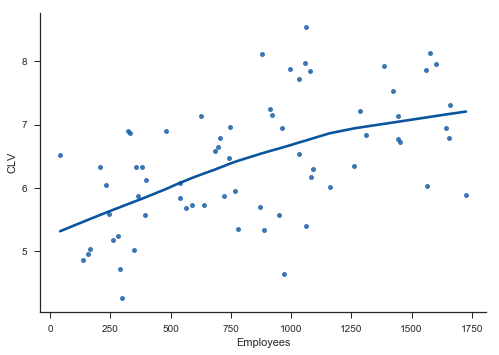

In [8]:
sns.regplot(train['Employees'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=sns.color_palette('Blues')[-1])
sns.despine()
plt.show()

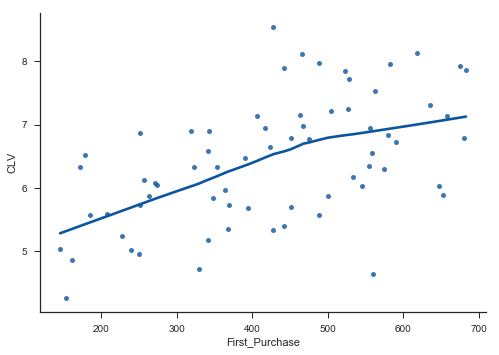

In [9]:
sns.regplot(train['First_Purchase'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=sns.color_palette('Blues')[-1])
sns.despine()
plt.show()

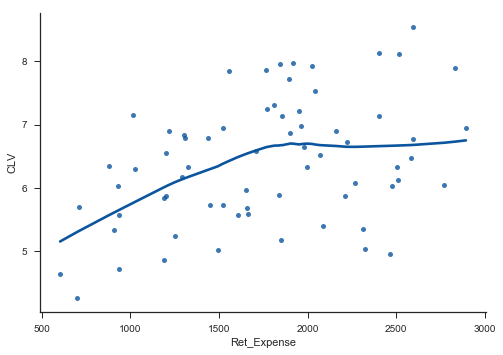

In [10]:
sns.regplot(train['Ret_Expense'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=sns.color_palette('Blues')[-1])
sns.despine()
plt.show()

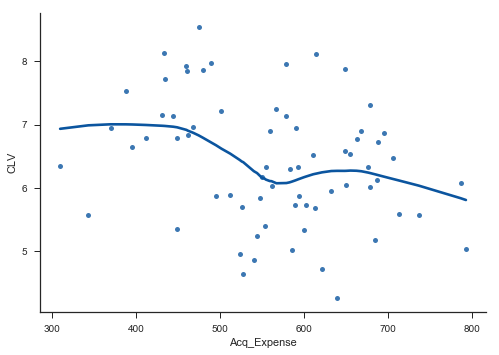

In [11]:
sns.regplot(train['Acq_Expense'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=sns.color_palette('Blues')[-1])
sns.despine()
plt.show()

###Standardising the predictors

The regularisation and dimension reduction methods in this tutorial, like many machine learning methods, require that first center and standardise the predictors (so that the transformed predictors have zero mean and unit standard deviation). We need to apply the same transformations to the predictors in the test data, where the mean and variance are based on the training data only.  

Alternatively, you can use the [standard scaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) from <TT>Scikit Learn</TT> for this task. 

In [12]:
mu=train[predictors].mean()
sigma=train[predictors].std()

train[predictors]=(train[predictors]-mu)/sigma
test[predictors]=(test[predictors]-mu)/sigma

###OLS


In [13]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(train[predictors], train[response])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

###Variable selection

Even though <TT>Scikit Learn</TT> has functionality for variable selection, they do not correspond to the methods that we have seen in the lecture. Therefore, we write code for variable selection separately in the statistical learning module. Our results will be based on forward selection.  

In [14]:
%%time
from statlearning import forward

fwd = forward()
fwd.fit(train[predictors], train[response])

Wall time: 1.57 s


###Regularisation methods

Starting with the lasso method, the [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) function is the most convenient implementation with built in model selection for the tuning parameter. 

In [15]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5)
lasso.fit(train[predictors], np.ravel(train[response])) # the np.ravel is a necessary detail for compatibility

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

The methods applies a high degree of shrinkage.

In [16]:
round(np.linalg.norm(lasso.coef_, ord=1)/np.linalg.norm(np.ravel(ols.coef_), ord=1),3)

0.111

The lasso sets several of the coefficients to zero. 

In [17]:
pd.DataFrame(lasso.coef_.round(3), index = predictors).T

,First_Purchase,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Frequency,Frequency_SQ,Crossbuy_2,Crossbuy_3,Crossbuy_4,Crossbuy_5,Crossbuy_6,I1,I2,I3,I4,I5,I6,I7,I8,First_Purchase_SQ,First_Purchase_CB,Employees_SQ,Employees_CB,Ret_Expense_CB
0,0.631,-0.0,-0.393,0.0,0.02,0.0,1.101,-0.0,0.582,-0.28,0.107,0.127,0.188,0.281,0.327,-0.0,0.095,0.163,-0.155,0.193,-0.0,-0.0,0.015,0.0,0.001,-0.0,-0.018,-0.605


In [18]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=lasso.alpha_)
lasso.fit(train[predictors], np.ravel(train[response]))

Lasso(alpha=0.0060231856242256472, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

The process is similar for ridge regression, except that we need to manually specify a grid on penalty values (called alpha by the package).

In [19]:
from sklearn.linear_model import RidgeCV

alphas = np.exp(np.linspace(-10,20,500)) 
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(train[predictors], np.ravel(train[response]))

RidgeCV(alphas=array([  4.53999e-05,   4.82131e-05, ...,   4.56856e+08,   4.85165e+08]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [20]:
print(round(np.linalg.norm(ridge.coef_)/np.linalg.norm(np.ravel(ols.coef_)), 3))

0.131


We store the model as a standard ridge regression object (this will save time for computing the cross validation results later). 

In [21]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=ridge.alpha_)
ridge.fit(train[predictors], np.ravel(train[response]))

Ridge(alpha=0.86911436148901855, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

The procedure for the elastic net is similar, except that in this case we need to specify a grid of values for the weight on the lasso and ridge penalties. 

In [22]:
from sklearn.linear_model import ElasticNetCV
enet = ElasticNetCV(l1_ratio=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99], cv=5)
enet.fit(train[predictors],np.ravel(train[response]))

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

As before, we store the model as a standard elastic net object.

In [23]:
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=enet.alpha_, l1_ratio=enet.l1_ratio_)
enet.fit(train[predictors],np.ravel(train[response]))

ElasticNet(alpha=0.0060840258830562131, copy_X=True, fit_intercept=True,
      l1_ratio=0.98999999999999999, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

###Dimension reduction methods

The principal components regression method does not currently exist in Python. We therefore need to write code to implement it separately, which is straightforward to do based on <TT>Scikit Learn</TT> class for [pincipal components analysis](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (PCA).  


In [24]:
from statlearning import pcrCV
pcr=pcrCV(train[predictors], train[response])

In the case of partial least squares, <TT>Scikit Learn</TT> has an [implementation](http://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html), but without automatic selection of the number of components. We therefore do this separately in the statistical learning modue. 

In [25]:
from statlearning import plsCV
pls=plsCV(train[predictors], train[response])

###Cross validation results

In this section, we implement cross validation to estimate the predictive performance of each method (given our choices of hyper-parameters above) based on the training data only. The results suggest that variable selection may be the best method given the available training data, with no clear distiction between the other methods. 

In [26]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Cross validator
kf=KFold(len(train), shuffle=True, random_state=1) 

# Methods
columns = ['CV RMSE']
rows = ['OLS', 'Forward', 'Ridge','Lasso', 'Elastic Net', 'PCR', 'PLS']

regressions = [ols, fwd, ridge, lasso, enet, pcr, pls]
results = pd.DataFrame(0.0, columns=columns, index=rows) # initialising a dataframe to hold the results

methods = {k: v for k, v in zip(rows, regressions)}

# Computing the results (Scikit Learn objects)
keys = ['OLS', 'Ridge','Lasso','Elastic Net','PLS']
for key in keys:
    scores = cross_val_score(methods[key], train[predictors], np.ravel(train[response]), cv=kf, scoring = 'neg_mean_squared_error')
    results.loc[key] = np.sqrt(-1*np.mean(scores))

# Computing the results (customised models)
keys = ['Forward', 'PCR']
for key in keys:
    results.loc[key] = methods[key].cv_score(train[predictors], np.ravel(train[response]), cv=kf)
    
results.round(3)

,CV RMSE
OLS,0.497
Forward,0.423
Ridge,0.484
Lasso,0.485
Elastic Net,0.485
PCR,0.482
PLS,0.506


###Test results

We find that in line with the cross validation results, forward selection has the lowest estimated test error. The lasso also has similar performance, even though we were not able to identify that this is the case based on the training data. Since the lasso also performs variable selection, the results suggest that this is the most critical feature for improving predictive performance in this problem. 

In [27]:
columns=['Test RMSE', 'SE', 'Test R2', 'SE']
rows=['OLS', 'Forward', 'Ridge', 'Lasso', 'Elastic Net', 'PCR', 'PLS']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

# from now on, we use the Jackknife method to be able to report the standard errors for the test results
from statlearning import rmse_jack, r2_jack 

methods=[ols, fwd, ridge, lasso, enet, pcr, pls]
i=0
for method in methods:
    pred=method.predict(test[predictors])
    results.iloc[i,0], results.iloc[i,1] = rmse_jack(test[response], pred)
    results.iloc[i,2], results.iloc[i,3] = r2_jack(test[response], pred)
    i+=1

results.round(3)

,Test RMSE,SE,Test R2,SE
OLS,0.589,0.047,0.594,0.084
Forward,0.441,0.032,0.772,0.052
Ridge,0.477,0.032,0.734,0.056
Lasso,0.443,0.031,0.770,0.050
Elastic Net,0.443,0.031,0.770,0.050
PCR,0.509,0.037,0.696,0.067
PLS,0.490,0.035,0.719,0.064
